In [ ]:
pip install cvzone

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install mediapipe

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import cv2
import numpy as np
import math
import time

from skimage import transform
from skimage import io
import matplotlib.pyplot as plt
import os
import numpy as np
from skimage.color import rgb2gray
import random

import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, Lambda ,Dense ,Flatten ,Dropout
from keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
from cvzone.HandTrackingModule import HandDetector

In [ ]:
cap = cv2.VideoCapture(0)
#0 is the ID number for web cam here

In [ ]:
detector = HandDetector(maxHands = 1)

In [ ]:
offset = 20
imgSize = 300

folder = "Data/J"
counter = 0

while True:
    success, img = cap.read()
    hands, img = detector.findHands(img)
    if hands:
        hand = hands[0]
        x, y, w, h = hand['bbox']
        imgWhite = np.ones((imgSize, imgSize, 3), np.uint8)*255
        imgCrop = img[y-offset:y + h+offset, x-offset:x + w+offset]
        imgCropShape = imgCrop.shape
        
        
        aspectRatio = h/w
        if aspectRatio > 1:
            k = imgSize/h
            wCal = math.ceil(k*w)
            imgResize = cv2.resize(imgCrop, (wCal, imgSize))
            imgResizeShape = imgResize.shape
            wGap = math.ceil((imgSize - wCal)/2)
            imgWhite[:, wGap:wCal + wGap] = imgResize
            
        else:
            k = imgSize/w
            hCal = math.ceil(k*h)
            imgResize = cv2.resize(imgCrop, (hCal, imgSize))
            imgResizeShape = imgResize.shape
            hGap = math.ceil((imgSize - hCal)/2)
            imgWhite[:, hGap:hCal + hGap] = imgResize
            
        cv2.imshow("ImageCrop", imgCrop)
        cv2.imshow("ImageWhite", imgWhite)
    cv2.imshow('Image', img)
    key = cv2.waitKey(1)
    if key == ord("s"):
        counter += 1
        cv2.imwrite(f'{folder}/Image_{time.time()}.jpg', imgWhite)
        print(counter)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [ ]:
def load_data(data_directory):
    directories = [d for d in os.listdir(data_directory) 
                   if os.path.isdir(os.path.join(data_directory, d))]
    labels = []
    images = []
    for d in directories:
        label_directory = os.path.join(data_directory, d)
        file_names = [os.path.join(label_directory, f) for f in os.listdir(label_directory)]
        for f in file_names:
            images.append(io.imread(f))
            labels.append(ord(d))
    return images, labels

ROOT_PATH = "C:/Users/debop/OneDrive/Desktop"
train_data_directory=os.path.join(ROOT_PATH, "Train")

images, labels=load_data(train_data_directory)

In [ ]:
#evaluluation set for testing 

eval_data_directory = "/Users/debop/OneDrive/Desktop/Test"

In [ ]:
uniq_labels = sorted(os.listdir(train_data_directory))
images, labels = load_data(train_data_directory)

if uniq_labels == sorted(os.listdir(eval_data_directory)):
    X_eval, y_eval = load_data(eval_data_directory)

In [ ]:
images_array = np.array(images)
labels_array = np.array(labels)


# Count the number of labels
print("Total No of classes:",len(set(labels_array)))
print("Label Array: ",[chr(X) for X in set(labels)])

Total No of classes: 26
Label Array:  ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


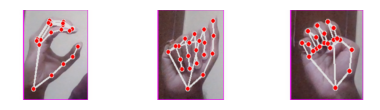

shape: (300, 300, 3), min: 0, max: 255


In [ ]:
# Determine the (random) indexes of the images that you want to see 
hand_signs = [256, 34, 434]

# Fill out the subplots with the random images that you defined 
for i in range(len(hand_signs)):
    plt.subplot(1, 4, i+1)
    plt.axis('off')
    plt.imshow(images[hand_signs[i]])
    plt.subplots_adjust(wspace=0.5)

plt.show()

print("shape: {0}, min: {1}, max: {2}".format(images[hand_signs[i]].shape, 
                                                  images[hand_signs[i]].min(), 
                                                  images[hand_signs[i]].max()))

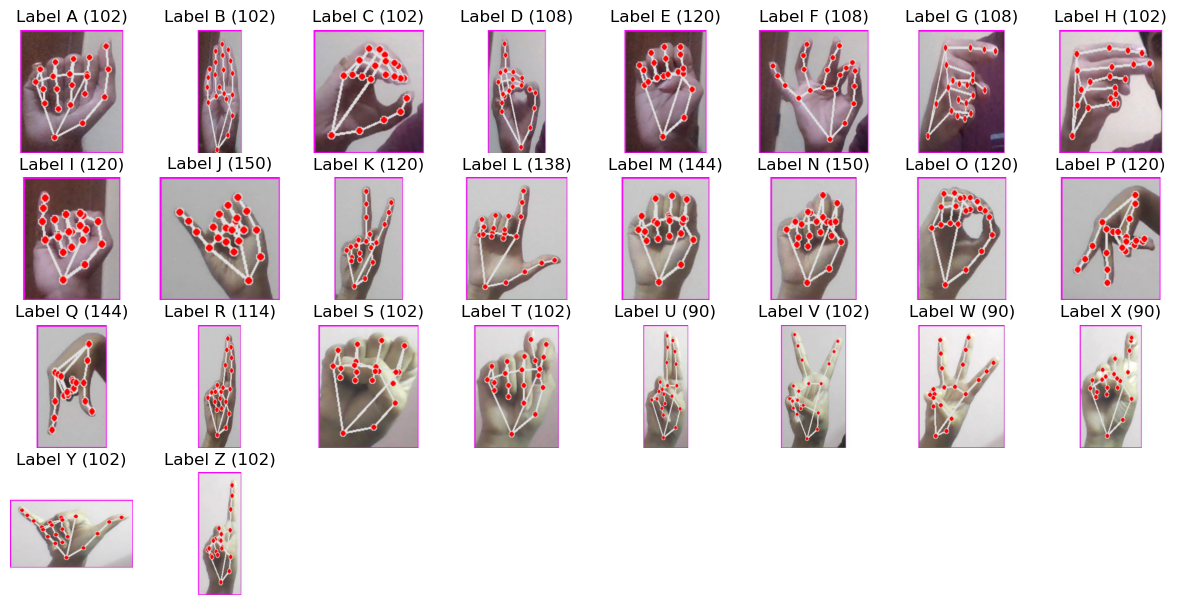

In [ ]:
# Get the unique labels 
unique_labels = set(labels)

# Initialize the figure
plt.figure(figsize=(15, 15))

# Set a counter
i = 1

# For each unique label,
for label in unique_labels:
    # You pick the first image for each label
    image = images[labels.index(label)]
    # Define 64 subplots 
    plt.subplot(8, 8, i)
    # Don't include axes
    plt.axis('off')
    # Add a title to each subplot 
    plt.title("Label {0} ({1})".format(chr(label), labels.count(label)))
    # Add 1 to the counter
    i += 1
    # And you plot this first image 
    plt.imshow(image)
    
# Show the plot
plt.show()

In [ ]:
# Resize images
images32 = [transform.resize(image, (64, 64, 3)) for image in images]
images32 = np.array(images32)

In [ ]:
images32 = rgb2gray(np.array(images32))

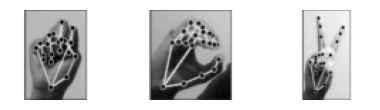

(499, 64, 64)


In [ ]:
for i in range(len(hand_signs)):
    plt.subplot(1, 4, i+1)
    plt.axis('off')
    plt.imshow(images32[hand_signs[i]], cmap="gray")
    plt.subplots_adjust(wspace=0.5)
    
plt.show()

print(images32.shape)

# Modelling using ResNet50

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images32, labels, test_size = 0.2, stratify = labels)

In [ ]:
#Normalization will help us remove distortions caused by lights and shadows in an image
X_train = np.array(X_train).astype('float32')/255.0
X_test = np.array(X_test).astype('float32')/255.0
X_eval = np.array(X_eval).astype('float32')/255.0

In [ ]:
#One hot encoding the target feature
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
y_eval = keras.utils.to_categorical(y_eval)

In [ ]:
classifier_resnet = ResNet50(input_shape= (64,64,3),include_top=False,weights='imagenet')

In [ ]:
#For not training existing weights for resnet50
for layer in classifier_resnet.layers:
    layer.trainable = False

In [ ]:
classifier = classifier_resnet.output#head mode
classifier = Flatten()(classifier)#adding layer of flatten
classifier = Dropout(0.6)(classifier)
classifier = Dense(units=91, activation='softmax')(classifier)

model = Model(inputs = classifier_resnet.input , outputs = classifier)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_16[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 16, 16, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 16, 16, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 16, 16, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_block3_3_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv2_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 8, 8, 128)   0           ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 8, 8, 512)    66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_block3_3_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv3_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 4, 4, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 4, 4, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 4, 4, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_block2_3_bn (BatchNormal  (None, 4, 4, 1024)  4096        ['conv4_block2_3_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 4, 4, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 4, 4, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 4, 4, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 2, 2, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 2, 2, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 2, 2, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_blo

In [ ]:
#fitting the model
history = model.fit(X_train, y_train, epochs = 10, batch_size = 64,validation_data=(X_test,y_test))

Epoch 1/10
37/37 [==============================] - 26s 612ms/step - loss: 3.7712 - accuracy: 0.0424 - val_loss: 3.2912 - val_accuracy: 0.0508
Epoch 2/10
37/37 [==============================] - 24s 658ms/step - loss: 3.4251 - accuracy: 0.0411 - val_loss: 3.2810 - val_accuracy: 0.0508
Epoch 3/10
37/37 [==============================] - 24s 656ms/step - loss: 3.3730 - accuracy: 0.0411 - val_loss: 3.2760 - val_accuracy: 0.0406
Epoch 4/10
37/37 [==============================] - 24s 651ms/step - loss: 3.3530 - accuracy: 0.0428 - val_loss: 3.2706 - val_accuracy: 0.0355
Epoch 5/10
37/37 [==============================] - 24s 653ms/step - loss: 3.3224 - accuracy: 0.0445 - val_loss: 3.2637 - val_accuracy: 0.0406
Epoch 6/10
37/37 [==============================] - 24s 660ms/step - loss: 3.3382 - accuracy: 0.0449 - val_loss: 3.2842 - val_accuracy: 0.0406
Epoch 7/10
37/37 [==============================] - 25s 690ms/step - loss: 3.3429 - accuracy: 0.0415 - val_loss: 3.2617 - val_accuracy: 0.0508

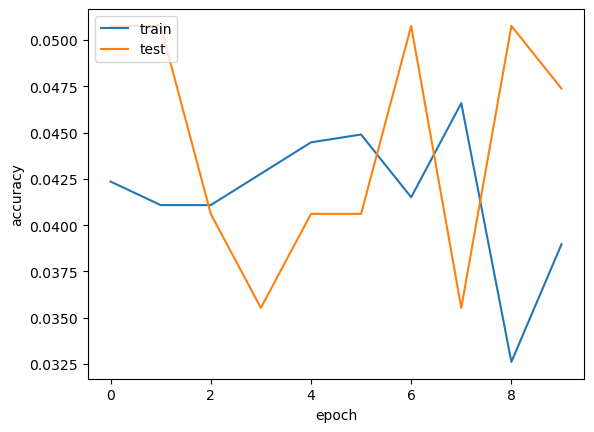

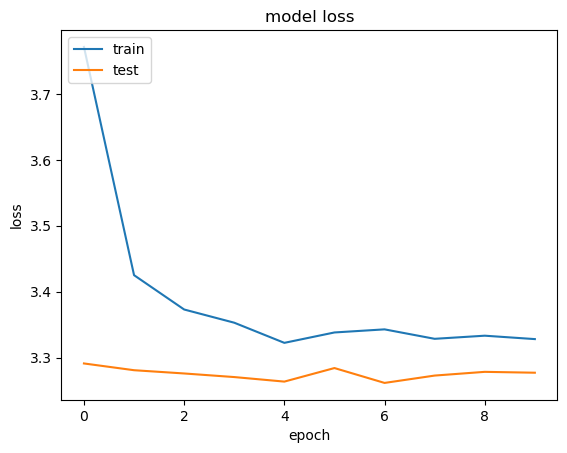

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
